# 06. COVID-19 Growth Prediction Model

This notebook implements a machine learning model to predict whether a country will experience high growth in COVID-19 cases based on its current statistics.

### Objective:
Predict "HighGrowth" (defined as 1-week % increase > 20%) using metrics like Confirmed, Deaths, Recovered, Active, and WHO Region.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

sns.set(style="whitegrid")

## Korak 1 – Priprema podataka

In [2]:
df = pd.read_csv('../archive/country_wise_latest.csv')

features_num = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered']
features_cat = ['WHO Region']
target_col = '1 week % increase'

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

threshold = 20
df['HighGrowth'] = (df[target_col] > threshold).astype(int)

print(f"Distribucija klasa:\n{df['HighGrowth'].value_counts()}")

df_final = pd.get_dummies(df[features_num + features_cat + ['HighGrowth']], columns=['WHO Region'])

df_final.head()

Distribucija klasa:
HighGrowth
0    151
1     36
Name: count, dtype: int64


,Confirmed,Deaths,Recovered,Active,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,HighGrowth,WHO Region_Africa,WHO Region_Americas,WHO Region_Eastern Mediterranean,WHO Region_Europe,WHO Region_South-East Asia,WHO Region_Western Pacific
0,36263,1269,25198,9796,3.50,69.49,5.04,0,False,False,True,False,False,False
1,4880,144,2745,1991,2.95,56.25,5.25,0,False,False,False,True,False,False
2,27973,1163,18837,7973,4.16,67.34,6.17,0,True,False,False,False,False,False
3,907,52,803,52,5.73,88.53,6.48,0,False,False,False,True,False,False
4,950,41,242,667,4.32,25.47,16.94,1,True,False,False,False,False,False


## Korak 2 – Podjela i treniranje modela

In [ ]:
X = df_final.drop('HighGrowth', axis=1)
y = df_final['HighGrowth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[features_num] = scaler.fit_transform(X_train[features_num])
X_test_scaled[features_num] = scaler.transform(X_test[features_num])

lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## Korak 3 – Evaluacija

--- Logistic Regression ---
Accuracy: 0.8158
F1 Score: 0.4615
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        31
           1       0.50      0.43      0.46         7

    accuracy                           0.82        38
   macro avg       0.69      0.67      0.68        38
weighted avg       0.81      0.82      0.81        38



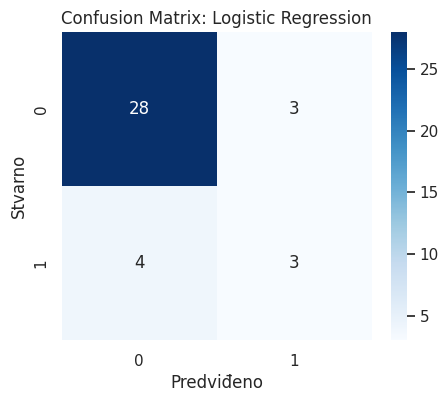

--- Random Forest ---
Accuracy: 0.7632
F1 Score: 0.1818
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        31
           1       0.25      0.14      0.18         7

    accuracy                           0.76        38
   macro avg       0.54      0.52      0.52        38
weighted avg       0.72      0.76      0.74        38



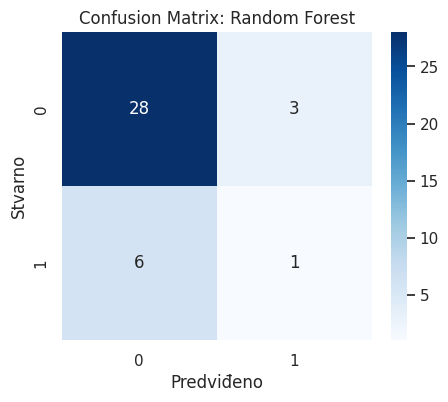

(0.7631578947368421, 0.18181818181818182)

In [4]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Stvarno')
    plt.xlabel('Predviđeno')
    plt.show()
    return acc, f1

evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest")

## Korak 4 – Objašnjenje rezultata

/tmp/ipykernel_9462/193811213.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeffs, palette='vlag')


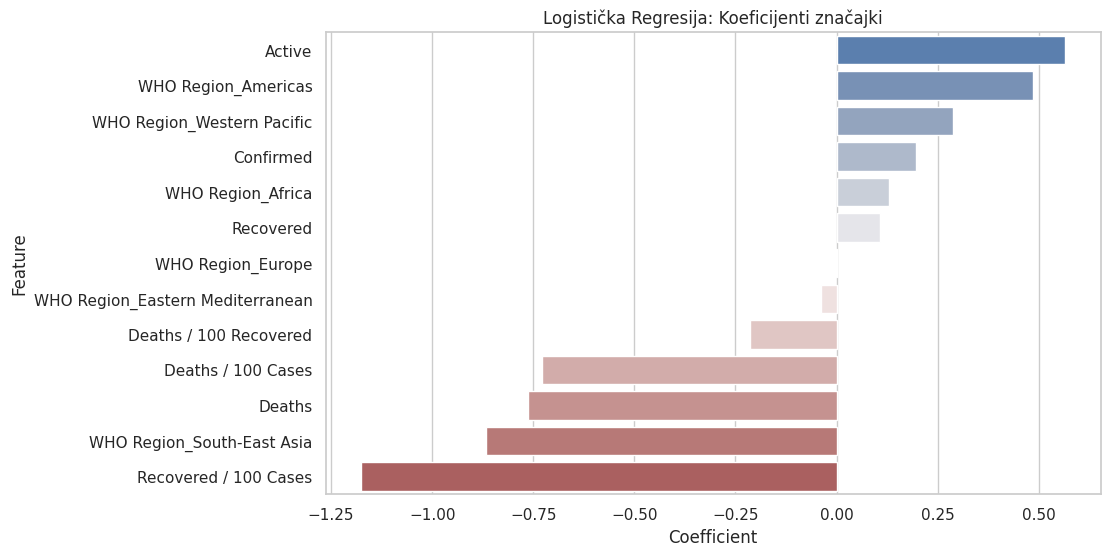

Interpretacija Logističke Regresije:
Značajke s pozitivnim koeficijentom povećavaju šansu za 'HighGrowth'.


In [5]:
coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeffs, palette='vlag')
plt.title('Logistička Regresija: Koeficijenti značajki')
plt.show()

print("Interpretacija Logističke Regresije:")
print("Značajke s pozitivnim koeficijentom povećavaju šansu za 'HighGrowth'.")

/tmp/ipykernel_9462/860848311.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette='magma')


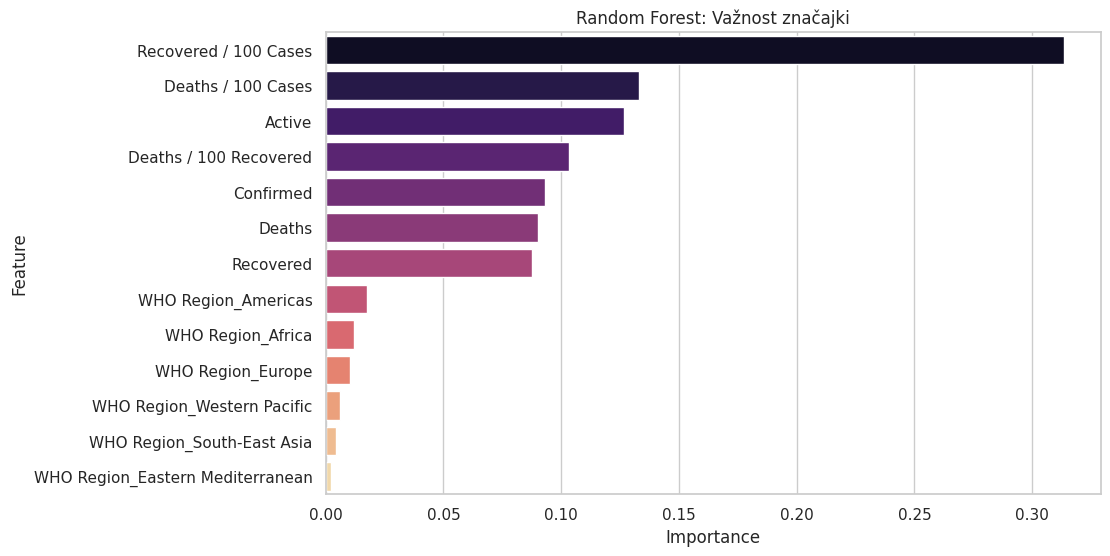

In [6]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='magma')
plt.title('Random Forest: Važnost značajki')
plt.show()

In [7]:
high_growth_countries = df[df['HighGrowth'] == 1][['Country/Region', 'Confirmed', 'Active', '1 week % increase', 'WHO Region']].sort_values(by='1 week % increase', ascending=False)
print("Top 10 država s najvećim tjednim porastom:")
print(high_growth_countries.head(10))

Top 10 država s najvećim tjednim porastom:
       Country/Region  Confirmed  Active  1 week % increase  \
130  Papua New Guinea         62      51             226.32   
63             Gambia        326     252             191.07   
11            Bahamas        382     280             119.54   
186          Zimbabwe       2704    2126              57.85   
99              Libya       2827    2186              42.78   
58           Ethiopia      14547    7933              42.52   
22           Botswana        739     674              41.57   
97            Lesotho        505     365              40.67   
160          Suriname       1483     534              37.44   
41         Costa Rica      15841   11902              37.34   

                WHO Region  
130        Western Pacific  
63                  Africa  
11                Americas  
186                 Africa  
99   Eastern Mediterranean  
58                  Africa  
22                  Africa  
97                  Africa  
16